# Benchmarking fklearn's space_time_split_dataset function

## Motivation
Issue: https://github.com/nubank/fklearn/issues/137

Pull request: https://github.com/nubank/fklearn/pull/138

In [1]:
from platform import python_version

print(python_version())

3.7.7


In [2]:
import fklearn

fklearn.__version__

'1.18.0'

In [3]:
import numpy as np

np.random.seed(42)

# Data
I will use fklearn's make_tutorial_data function to generate our data

# Original function
- Importing here the original `space_time_split_dataset` function (old)
- Defined below Jessica's version as `new_space_time_split_dataset`

In [4]:
from fklearn.data.datasets import make_tutorial_data
from fklearn.preprocessing.splitting import space_time_split_dataset

# Jessica's fix
Source: https://github.com/jessicadesousa/fklearn/blob/split-time-space-slow/src/fklearn/preprocessing/splitting.py

In [5]:
from typing import Tuple

import numpy as np
from numpy.random import RandomState
import pandas as pd
from toolz import curry

from fklearn.types import DateType

@curry
def new_space_time_split_dataset(dataset: pd.DataFrame,
                             train_start_date: DateType,
                             train_end_date: DateType,
                             holdout_end_date: DateType,
                             split_seed: int,
                             space_holdout_percentage: float,
                             space_column: str,
                             time_column: str,
                             holdout_space: np.ndarray = None,
                             holdout_start_date: DateType = None) -> Tuple[pd.DataFrame, ...]:
    """
    Splits panel data using both ID and Time columns, resulting in four datasets
    1. A training set;
    2. An in training time, but out sample id hold out dataset;
    3. An out of training time, but in sample id hold out dataset;
    4. An out of training time and out of sample id hold out dataset.
    Parameters
    ----------
    dataset : pandas.DataFrame
        A Pandas' DataFrame with an Identifier Column and a Date Column.
        The model will be trained to predict the target column
        from the features.
    train_start_date : str
        A date string representing a the starting time of the training data.
        It should be in the same format as the Date Column in `dataset`.
    train_end_date : str
        A date string representing a the ending time of the training data.
        This will also be used as the start date of the holdout period if no `holdout_start_date` is given.
        It should be in the same format as the Date Column in `dataset`.
    holdout_end_date : str
        A date string representing a the ending time of the holdout data.
        It should be in the same format as the Date Column in `dataset`.
    split_seed : int
        A seed used by the random number generator.
    space_holdout_percentage : float
        The out of id holdout size as a proportion of the in id training
        size.
    space_column : str
        The name of the Identifier column of `dataset`.
    time_column : str
        The name of the Date column of `dataset`.
    holdout_space : np.array
        An array containing the hold out IDs. If not specified,
        A random subset of IDs will be selected for holdout.
    holdout_start_date: str
        A date string representing the starting time of the holdout data.
        If `None` is given it will be equal to `train_end_date`.
        It should be in the same format as the Date Column in `dataset`.
    Returns
    ----------
    train_set : pandas.DataFrame
        The in ID sample and in time training set.
    intime_outspace_hdout : pandas.DataFrame
        The out of ID sample and in time hold out set.
    outime_inspace_hdout : pandas.DataFrame
        The in ID sample and out of time hold out set.
    outime_outspace_hdout : pandas.DataFrame
        The out of ID sample and out of time hold out set.
    """
    holdout_start_date = holdout_start_date if holdout_start_date else train_end_date

    in_time_mask = (dataset[time_column] >= train_start_date) & (dataset[time_column] < train_end_date)
    out_time_mask = (dataset[time_column] >= holdout_start_date) & (dataset[time_column] < holdout_end_date)

    all_space_in_time = dataset[in_time_mask][space_column].unique()

    if holdout_space is None:
        # for repeatability
        state = RandomState(split_seed)
        train_period_space = np.sort(all_space_in_time)

        # randomly sample accounts from the train period to hold out
        partial_holdout_space = state.choice(train_period_space,
                                             int(space_holdout_percentage * len(train_period_space)),
                                             replace=False)

        in_space = pd.Index(all_space_in_time).difference(pd.Index(partial_holdout_space)).values

    else:
        in_space = pd.Index(all_space_in_time).difference(pd.Index(holdout_space)).values

    in_space_mask = dataset[space_column].isin(in_space)

    train_set = dataset[in_space_mask & in_time_mask]
    intime_outspace_hdout = dataset[~in_space_mask & in_time_mask]
    outtime_outspace_hdout = dataset[~in_space_mask & out_time_mask]
    outtime_inspace_hdout = dataset[in_space_mask & out_time_mask]

    return train_set, intime_outspace_hdout, outtime_inspace_hdout, outtime_outspace_hdout

In [6]:
TRAIN_START_DATE = '2015-01-01' 
TRAIN_END_DATE = '2015-03-01' 
HOLDOUT_END_DATE = '2015-04-01'

split_fn = space_time_split_dataset(train_start_date=TRAIN_START_DATE,
                                train_end_date=TRAIN_END_DATE,
                                holdout_end_date=HOLDOUT_END_DATE,
                                space_holdout_percentage=.5,
                                split_seed=42, 
                                space_column="id",
                                time_column="date")

new_split_fn = new_space_time_split_dataset(train_start_date=TRAIN_START_DATE,
                                train_end_date=TRAIN_END_DATE,
                                holdout_end_date=HOLDOUT_END_DATE,
                                space_holdout_percentage=.5,
                                split_seed=42, 
                                space_column="id",
                                time_column="date")

In [7]:
sample_sizes = [10000, 100000, 250000, 500000, 750000, 1000000]
data = make_tutorial_data(sample_sizes[-1])

In [11]:
old_function_times = []
new_function_times = []

for sample_size in sample_sizes:
    time_old = %timeit -r 1 -o split_fn(data[:sample_size])
    old_function_times.append(time_old.best)
    time_new = %timeit -r 1 -o new_split_fn(data[:sample_size])
    new_function_times.append(time_new.best)

7.32 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
7.33 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
27.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
27.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
60.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
59.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
115 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
113 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
170 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
168 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
226 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
223 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [12]:
old_function_times

[0.007322853000000009,
 0.027418999999999017,
 0.06013975000000045,
 0.11499270999999993,
 0.1698096199999995,
 0.22558290000000625]

In [13]:
new_function_times

[0.007327887000000004,
 0.02758636000000081,
 0.05994749999999982,
 0.11279924999999906,
 0.16823847,
 0.22343239999997877]

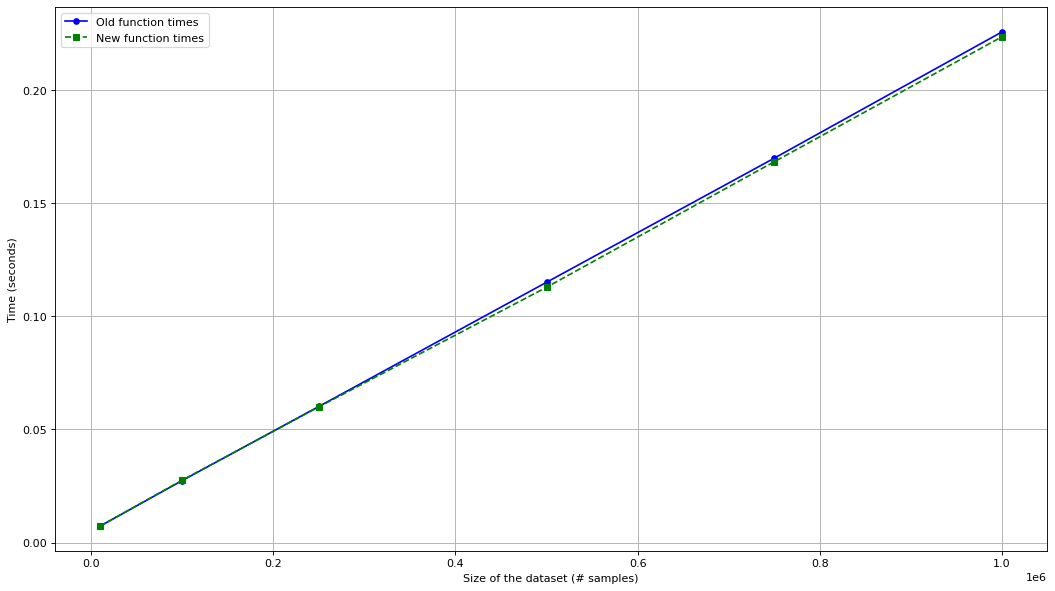

In [14]:
import matplotlib.pyplot as plt

plt.figure(dpi=80, figsize=(16, 9))
plt.plot(
    sample_sizes,
    old_function_times,
    color="blue",
    marker="o",
    markersize=5,
    label="Old function times",
)
plt.plot(
    sample_sizes,
    new_function_times,
    color="green",
    linestyle="--",
    marker="s",
    markersize=5,
    label="New function times",
)
plt.grid()
plt.xlabel("Size of the dataset (# samples)")
plt.ylabel("Time (seconds)")
plt.legend()
plt.show()

## Preliminary conclusions
- No difference between functions in execution time

## Data
- If we investigate the `make_tutorial_data` function we will see that:

```python
dataset = pd.DataFrame({
        "id": list(map(lambda x: "id%d" % x, np.random.randint(0, 100, n))),
        "date": np.random.choice(pd.date_range("2015-01-01", periods=100), n),
        "feature1": np.random.gamma(20, size=n),
        "feature2": np.random.normal(40, size=n),
        "feature3": np.random.choice(["a", "b", "c"], size=n)})
```

The id column is generated concatenating the string id and a random integer between 0 and 100, let's investigate the difference in execution time if we increase random integer range to 1M (probably increasing the uniques)

In [15]:
import numpy as np
from numpy import nan
import pandas as pd


def new_make_tutorial_data(n: int) -> pd.DataFrame:
    """
    Generates fake data for a tutorial. There are 3 numerical features ("num1", "num3" and "num3")
    and tow categorical features ("cat1" and "cat2")
    sex, age and severity, the treatment is a binary variable, medication and the response
    days until recovery.
    Parameters
    ----------
    n : int
        The number of samples to generate
    Returns
    ----------
    df : pd.DataFrame
        A tutorial dataset
    """
    np.random.seed(1111)

    dataset = pd.DataFrame({
        "id": list(map(lambda x: "id%d" % x, np.random.randint(0, 1000000, n))),
        "date": np.random.choice(pd.date_range("2015-01-01", periods=100), n),
        "feature1": np.random.gamma(20, size=n),
        "feature2": np.random.normal(40, size=n),
        "feature3": np.random.choice(["a", "b", "c"], size=n)})

    dataset["target"] = (dataset["feature1"]
                         + dataset["feature2"]
                         + dataset["feature3"].apply(lambda x: 0 if x == "a" else 30 if x == "b" else 10)
                         + np.random.normal(0, 5, size=n))

    # insert some NANs
    dataset.loc[np.random.randint(0, n, 100), "feature1"] = nan
    dataset.loc[np.random.randint(0, n, 100), "feature3"] = nan

    return dataset

In [16]:
sample_sizes = [10000, 100000, 250000, 500000, 750000, 1000000]
data = new_make_tutorial_data(sample_sizes[-1])

In [17]:
old_function_times = []
new_function_times = []

for sample_size in sample_sizes:
    time_old = %timeit -r 1 -o split_fn(data[:sample_size])
    old_function_times.append(time_old.best)
    time_new = %timeit -r 1 -o new_split_fn(data[:sample_size])
    new_function_times.append(time_new.best)

291 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
13.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
25 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
112 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2min 38s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
335 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8min 58s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
801 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
18min 8s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.26 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
29min 21s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.68 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [18]:
old_function_times

[0.2914055999999903,
 25.002141499999993,
 158.75621130000002,
 538.6514996000001,
 1088.5079799999999,
 1761.0925338999996]

In [19]:
new_function_times

[0.013109436000000016,
 0.11223484000000213,
 0.3350396000000728,
 0.80093480000005,
 1.2604999999998654,
 1.6836789999997563]

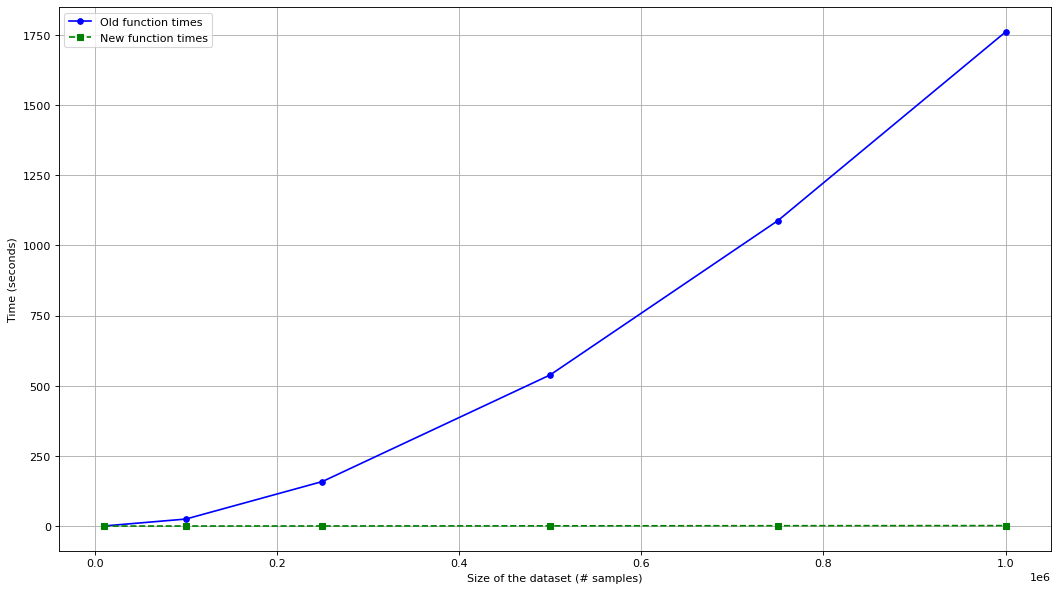

In [20]:
plt.figure(dpi=80, figsize=(16, 9))
plt.plot(
    sample_sizes,
    old_function_times,
    color="blue",
    marker="o",
    markersize=5,
    label="Old function times",
)
plt.plot(
    sample_sizes,
    new_function_times,
    color="green",
    linestyle="--",
    marker="s",
    markersize=5,
    label="New function times",
)
plt.grid()
plt.xlabel("Size of the dataset (# samples)")
plt.ylabel("Time (seconds)")
plt.legend()
plt.show()

In [21]:
old_function_times[-1] / new_function_times[-1]

1045.9787963740444

In [22]:
old_function_times[-2] / new_function_times[-2]

863.5525426419009

# Conclusions
- Major speed up (~1000x faster) for large datasets (1M rows) with many unique values in the `space_column`
- Pratically no difference in speed for datasets with few distinct values in the `space_column`

> "It takes about 30-60 minutes to split a 0.5-1million rows dataset, which seems somewhat excessive" - @tatasz

- The affirmative seems to be coherent with the times I found in my computer with 1M rows and `"id": list(map(lambda x: "id%d" % x, np.random.randint(0, 1000000, n)))` -> 29min 21s
- The fix by @jessicadesouza brings the time down from 29min 21s to 1.68s